In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA

In [2]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita_2.dropna(subset=['body_clean', 'title_clean'], inplace=True)

aita = aita_2[['body_polarity','body_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']
aita.dropna(inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
aita

,body_polarity,body_subjectivity,is_asshole,title_body_combo
0,-0.156818,0.656818,1,I write an explanation in til and come off a...
1,0.034848,0.449242,1,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0,I tell a goth girl she look like a clownI be four
3,0.000000,0.000000,1,argument I have with another redditor in rhi...
4,0.040104,0.369792,1,have a disagreement about le miserable with ...
...,...,...,...,...
97536,0.016111,0.385278,0,for tell my sister she be be a spoiled bratm...
97537,0.068461,0.474614,0,for tell my husband to f off after he relent...
97538,-0.076333,0.493467,0,for attempt to keep my student out of adult ...
97539,0.067130,0.426132,0,if I leave my brother fate up to the statea ...


In [4]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=11)

In [5]:
X_train.shape, X_test.shape

((96480, 3), (975, 3))

## Instantiate CountVectorizer 

In [8]:
stop = set(stopwords.words('english'))
vec = CountVectorizer(stop_words=stop, min_df=0.01, max_df=0.8, ngram_range=(1, 2))
cv = vec.fit(X_train['title_body_combo'])

In [11]:
len(vec.get_feature_names())

1938

### Save fitted CountVectorizer to use later

In [11]:
# pickle.dump(cv, open('models/cv_fit_train.sav', 'wb'))

### Load fitted CountVectorizer

In [6]:
# cv = pickle.load(open('models/cv_fit_train.sav', 'rb'))

In [2]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])

NameError: name 'cv' is not defined

In [13]:
cv_cols = cv.get_feature_names()

In [1]:
dtm_train_arr = cv_train.toarray()

NameError: name 'cv_train' is not defined

In [ ]:
dtm_test_arr = cv_test.toarray()

In [ ]:
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols)

In [1]:
train_word_count = dtm_train.sum(axis=0)
train_word_count.sort_values(ascending=False)[:20]

NameError: name 'dtm_train' is not defined

In [12]:
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols)
test_word_count = dtm_test.sum(axis=0)
test_word_count.sort_values(ascending=False)[:10]

get       2354
say       1991
go        1967
tell      1704
want      1680
would     1608
like      1352
friend    1291
time      1262
know      1147
dtype: int64

In [14]:
# ((96480, 44051), (975, 44051))
dtm_train.shape, dtm_test.shape

((96480, 44051), (975, 44051))

### Save / Load Document Term Matrix to / from csv

In [2]:
# dtm_train.to_csv('data/dtm_train.csv', index=False)
# dtm_test.to_csv('data/dtm_test.csv', index=False)

dtm_train = pd.read_csv('data/dtm_train.csv')
dtm_test = pd.read_csv('data/dtm_test.csv')

KeyboardInterrupt: 

## PCA

In [16]:
pca = IncrementalPCA(n_components=800, batch_size=850)
pca.fit(dtm_train)
print(pca.explained_variance_ratio_.sum())

0.6878782983410767


### Save / Load fitted PCA Model

In [17]:
pickle.dump(pca, open('models/pca.sav', 'wb'))

# pca = pickle.load(open('models/pca.sav', 'rb'))
# pca

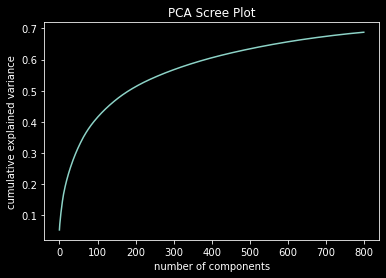

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PCA Scree Plot')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

### Transform train and test Document-Term-matrix with PCA

In [20]:
dtm_train_pca = pca.transform(dtm_train)
dtm_test_pca = pca.transform(dtm_test)

Build DataFrame of PCA Components

In [21]:
col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names)
dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names)

Combine PCA components and sentiment analysis scores into one DataFrame

In [22]:
X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']].reset_index(drop=True), dtm_train_pca_df], axis=1)
X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']].reset_index(drop=True),dtm_test_pca_df], axis=1)

In [23]:
X_train_post_dtm_pca.head()

,body_polarity,body_subjectivity,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,...,PC_791,PC_792,PC_793,PC_794,PC_795,PC_796,PC_797,PC_798,PC_799,PC_800
0,0.089698,0.382755,6.728525,3.948646,-3.479711,-2.477202,-1.816928,-1.500501,-4.192668,3.963466,...,-0.226437,-0.417146,0.564844,-0.009604,-0.035552,-0.307510,0.180318,-0.109446,-0.027887,0.194491
1,-0.140000,0.601585,5.770071,0.613699,-2.259459,-3.158205,-1.177350,-2.200651,-2.934554,0.080828,...,-0.058680,-0.003839,-0.072919,-0.758598,0.004823,0.724527,-0.747231,0.148913,-0.543629,-0.085037
2,0.034758,0.575265,1.964644,-1.710377,-0.905220,0.229871,0.972525,5.882006,1.319236,-1.062495,...,0.010503,0.036585,0.001279,0.081791,-0.041667,-0.077339,-0.055103,-0.145997,0.108385,0.020977
3,-0.009470,0.545676,-0.269937,0.266015,2.149530,-2.281590,-2.741762,-2.705606,-0.531522,0.210982,...,-0.527014,0.729150,-0.657591,-0.056549,-0.344287,0.004941,-0.069512,-0.397783,0.200470,-0.004434
4,0.196644,0.494792,2.398916,-0.613953,-0.244876,-3.199293,-1.277492,1.058647,4.112951,2.735212,...,-0.252945,-0.221736,-0.127584,0.134080,0.293271,-0.055766,0.023604,0.129646,-0.158489,-0.183404


In [24]:
print(X_train_post_dtm_pca.shape, y_train.shape)
print(X_test_post_dtm_pca.shape, y_test.shape)

(96480, 802) (96480,)
(975, 802) (975,)


## Random Forest Models

### 1. Vanilla Random Forest, no tuning hyperparameters 

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X_train_post_dtm_pca, y_train)

RandomForestClassifier()

In [26]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [27]:
print(f'Training Accuracy = {rfc.score(X_train_post_dtm_pca, y_train)}')

Training Accuracy = 1.0


In [30]:
print(f'Testing Accuracy = {rfc.score(X_test_post_dtm_pca, y_test)}')

Testing Accuracy = 0.7230769230769231


In [35]:
cross_val_score(rfc, X_train_post_dtm_pca, y_train, cv=5, scoring='f1')

array([0.01342282, 0.01713222, 0.01346046, 0.01753404, 0.01570093])

In [37]:
y_pred_train = rfc.predict(X_train_post_dtm_pca)

In [44]:
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))

[[70299     0]
 [    0 26181]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70299
           1       1.00      1.00      1.00     26181

    accuracy                           1.00     96480
   macro avg       1.00      1.00      1.00     96480
weighted avg       1.00      1.00      1.00     96480



In [42]:
y_pred_test = rfc.predict(X_test_post_dtm_pca)

In [43]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[704   6]
 [264   1]]
              precision    recall  f1-score   support

           0       0.73      0.99      0.84       710
           1       0.14      0.00      0.01       265

    accuracy                           0.72       975
   macro avg       0.44      0.50      0.42       975
weighted avg       0.57      0.72      0.61       975

